# CerealTimeKillersNet: Deep neural network for emotional states predictions from EEG data.

## Setup

In [1]:
# Packages & self-implemented functions
from CTKNetFunctions import *


## Model settings - Change models here!

In [2]:
class CTKNet_CNN(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTKNet_CNN, self).__init__()
        
        # Model hyperparametres (layer by layer)
        conv_channel = [20, 10, 5]
        conv_kernel = [3, 5, 10]
        pool_kernel = [1, 2, 2]
        fc_unit = [128, 64]
        drop_out = [0.5, 0.5]
        
        # Hidden layers
        img_size = np.array(input_shape[1:])
        
        self.conv1 = nn.Conv2d(in_channels = input_shape[0], out_channels = conv_channel[0], kernel_size = conv_kernel[0])
        # self.bn1 = nn.BatchNorm2d(conv_channel[0])
        self.pool1 = nn.MaxPool2d(kernel_size = pool_kernel[0])
        img_size = np.floor((img_size - conv_kernel[0] + 1.0) / pool_kernel[0])
        
        self.conv2 = nn.Conv2d(in_channels = conv_channel[0], out_channels = conv_channel[1], kernel_size = conv_kernel[1])
        # self.bn2 = nn.BatchNorm2d(conv_channel[1])
        self.pool2 = nn.MaxPool2d(kernel_size = pool_kernel[1])
        img_size = np.floor((img_size - conv_kernel[1] + 1.0) / pool_kernel[1])
        
        self.conv3 = nn.Conv2d(in_channels = conv_channel[1], out_channels = conv_channel[2], kernel_size = conv_kernel[2])
        # self.bn3 = nn.BatchNorm2d(conv_channel[2])
        self.pool3 = nn.MaxPool2d(kernel_size = pool_kernel[2])
        img_size = np.floor((img_size - conv_kernel[2] + 1.0) / pool_kernel[2])
        
        fc_input_size = int(np.prod(img_size) * conv_channel[2])
        
        self.fc1 = nn.Linear(in_features = fc_input_size, out_features = fc_unit[0])
        self.drop1 = nn.Dropout(drop_out[0])
        
        self.fc2 = nn.Linear(in_features = fc_unit[0], out_features = fc_unit[1])
        self.drop2 = nn.Dropout(drop_out[1])
        
        self.fc3 = nn.Linear(in_features = fc_unit[1], out_features = out_size[0])

        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        # x = self.bn1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        # x = self.bn2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        # x = self.bn3(x)
        x = self.pool3(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.drop1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = self.drop2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = torch.sigmoid(x)
        
        return x


In [3]:
# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTKNet_CNN(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


In [4]:
# Main function of model simulation
def CerealTimeKillersModelSimulator(args, label,
                                    TrainDataLoader, ValDataLoader, TestDataLoader, DataSize,
                                    is_2D = False,
                                    K_fold_train = False, k_folds = 1):
    
    N_FOLD = k_folds if K_fold_train else 1
    loss, acc, param, models = [], [], [], []
    
    for fold in range(N_FOLD):
        print('\n%d/%d Fold' % (fold + 1, N_FOLD))
        print('----------------------------')
    
        model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
        loss_list, acc_list, param_norm_list, trained_model, epoch = simulation(args, label, model,
                                                                                TrainDataLoader[fold],
                                                                                ValDataLoader[fold],
                                                                                TestDataLoader,
                                                                                is_2D = is_2D,
                                                                                optimizer = optimizer,
                                                                                criterion = criterion)
    
        loss_list, acc_list = np.array(loss_list), np.array(acc_list)
        loss.append([loss_list[0, epoch], loss_list[1, epoch], loss_list[2, epoch]])
        acc.append([acc_list[0, epoch], acc_list[1, epoch], acc_list[2, epoch]])
        param.append(param_norm_list[epoch])
        models.append(trained_model)
        
        print('Train/Val/Test Final MSE:', list(loss[-1]))
        print('Train/Val/Test Maximum Accuracy:', list(acc[-1]))
    
    return loss, acc, param, models



## Input settings - Change hypermatres here!

In [5]:
class CerealTimeKillersLabels:
    """
    Select labels for model prediction
    Labels used for prediction: info + electrode --> prediction
    CHANGE these with necessity before loading data
    """
    
    # ['subject', 'game', 'gender', 'age', 'disturbance', 'experience', 'memory']
    info = []
        
    # ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    electrode = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
        
    # ['satisfied', 'boring', 'horrible', 'calm', 'funny', 'valence', 'arousal']
    # prediction = ['boring', 'horrible', 'calm', 'funny']
    prediction = ['valence', 'arousal']
    
    # Quadrant emotions (applied after predicting valence/arousal)
    quadrant = ['boring', 'horrible', 'calm', 'funny']
    
    # Fixed variables
    fixed = info + prediction
    
    # Summarise labels for model
    label = info + electrode + prediction


In [6]:
# General settings
workspace_dir = '' # Workspace directionary
LabelRange = [1, 9] # The [min, max] of emotional states for transformation

# Whether to allow between-window dataset mixture
# SET TO FALSE FOR 4-DIMENSIONAL INPUT WHEN USING RNN
Is_between_subject = True # Default is True for 3-dimensional input

# Whether to transform 2D emotion  (valence/arousal) to 4 quardrant emotions ()
Is_2D_to_quardrant_emotion = True # Default is False

# Which to be based for allocating testing dataset (only when Is_between_subject = True)
Allocation_test = None # [None, 'subject', 'game'] # Default is None
test_ratio = 0.2 # Proportion of data used for testing when Allocation_test == None
Target_test = [25, 26, 27] # Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None

# Model structural settings
N_inputtime = None # Time window for input sampling (Default is None for the whole timepoints)
N_stridetime = N_inputtime # Temporal leap for input sampling when N_inputtime != None
N_perseg = 256 # N per seg of spectrogram
N_framerate = 128 # Framerate of spectrogram

# Model training settings
batch_size_train = 16 # Number of examples per minibatch during training
batch_size_test = 1 # Number of examples per minibatch during validation/testing
k_folds = 5 # Number for K-folds for training vs validation (validation is 1/k_folds of the train/val set)
K_fold_train = True # Whether enable the full K-fold cross-validation for training (if False, validate only once)

# Model hypermparametres
args = {
    'epochs': 300,
    'lr': 3e-3,
    'momentum': 0.99,
    'l1': 1e-3,
    'l2': 1e-3,
    'patience': 30,
    'device': set_device(),
}
print('Current device:', args['device'])

# Set random seed for reproducibility
SEED = 2021
set_seed(seed = SEED)
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Torch-based data transformation
data_transform = None


Current device: cpu
Random seed 2021 has been set.


## MAIN CODE

In [7]:
# Implement Dataloader
FullDataset, DataSize, ExpIndex = CerealTimeKillersDataLoader(dir_base = workspace_dir,
                                                              label_class = CerealTimeKillersLabels,
                                                              label_range = LabelRange,
                                                              dataset_mix = Is_between_subject,
                                                              winlen = N_inputtime,
                                                              stride = N_stridetime,
                                                              nperseg = N_perseg,
                                                              fs = N_framerate,
                                                              transform = data_transform)

# Implement DataSplitter
SplittedDataset, SplittedDataLength = CerealTimeKillersDataSplitter(FullDataset, 
                                                                    exp_index = ExpIndex, 
                                                                    allocation_test = Allocation_test,
                                                                    test_ratio = test_ratio,
                                                                    target_test = Target_test,
                                                                    k_folds = k_folds,
                                                                    batch_size_train = batch_size_train,
                                                                    batch_size_test = batch_size_test,
                                                                    seed = SEED,
                                                                    generator = g_seed)

# Load Splited data
(TrainDataLoader, ValDataLoader, TestDataLoader) = (SplittedDataset['train'],
                                                    SplittedDataset['val'],
                                                    SplittedDataset['test'])

# Show data size
print('Dataset length:', SplittedDataLength)
print('Input shape: [channel, frequency, time]')
print('Single input data size:', DataSize[0])
print('Single output data size:', DataSize[1])


Dataset length: {'train': 70, 'val': 17, 'test': 21}
Input shape: [channel, frequency, time]
Single input data size: (14, 129, 170)
Single output data size: (2,)


In [8]:
# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
summary(model, DataSize[0])


CTKNet(
  (conv1): Conv2d(14, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 5, kernel_size=(10, 10), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4680, out_features=128, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 20, 127, 168]           2,540
         MaxPool2d-2         [-1, 20, 127, 168]               0
            Conv2d-3      

/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



1/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.08079947531223297 0.0736414102721028 0.07253295626252934
Train/Val/TEST Accuracy: 65.21739130434783 27.77777777777778 38.095238095238095
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.06290980577468872 0.07513524535655354 0.06666211779589676
Train/Val/TEST Accuracy: 69.56521739130434 44.44444444444444 66.66666666666667
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.04721231982111931 0.08162392029124829 0.07836110657081008
Train/Val/TEST Accuracy: 72.46376811594203 33.333333333333336 61.904761904761905
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.04552293866872788 0.08363914877797167 0.07287568705422538
Train/Val/TEST Accuracy: 76.81159420289855 55.55555555555556 66.66666666666667
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.03530635051429272 0.09252716916509801 0.08345610834103787
Train/Val/TEST Accuracy: 81.15942028985508 55.55555555555556 66.66666666666667
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.03533271923661232 0.09068068391126063 0.083155430121613

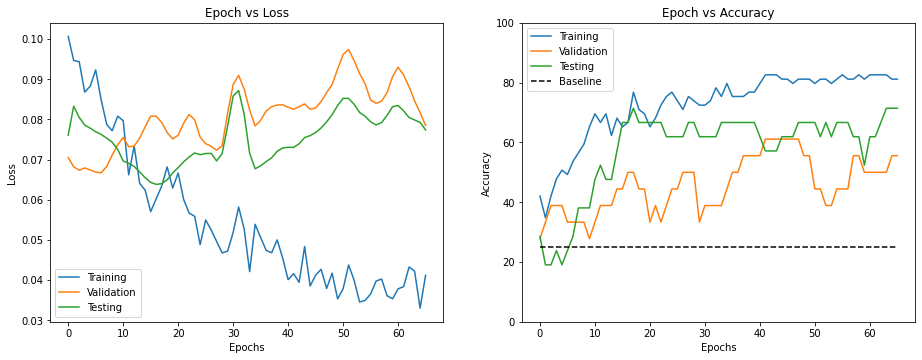

Train/Val/Test Final MSE: [0.053874583542346956, 0.07837502922888638, 0.06770799601716655]
Train/Val/Test Maximum Accuracy: [79.71014492753623, 44.44444444444444, 66.66666666666667]

2/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.07850571870803832 0.09437128490470867 0.0668854712774711
Train/Val/TEST Accuracy: 57.971014492753625 22.22222222222222 57.142857142857146
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.07050433680415154 0.09356269738539898 0.06499814087389193
Train/Val/TEST Accuracy: 68.1159420289855 38.888888888888886 66.66666666666667
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.046320277452468875 0.11226126620183802 0.054658303624906
Train/Val/TEST Accuracy: 78.26086956521739 22.22222222222222 71.42857142857143
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.04345073513686657 0.13484900954386425 0.06518896329881889
Train/Val/TEST Accuracy: 82.6086956521739 27.77777777777778 66.66666666666667
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.038250744342803955 0.12890179090512296 0.07108707220426627
Train/Val/TEST Accuracy: 79.71014492753623 27.77777777777778 61.904761904761905
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.034214378148317334 0.14359898999747303 0.081780670864862

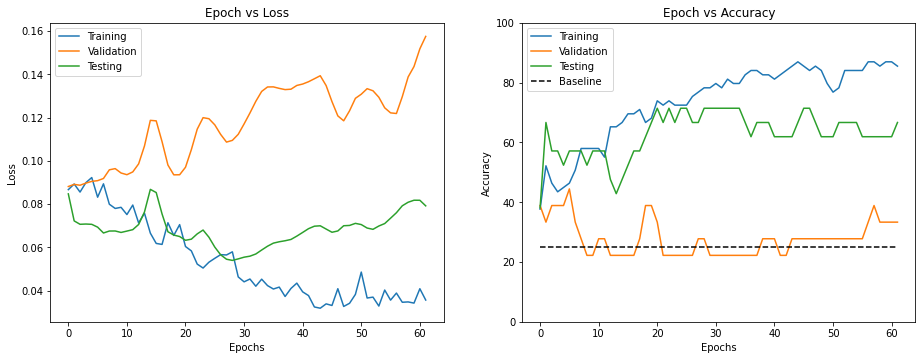

Train/Val/Test Final MSE: [0.04405272752046585, 0.117054278735951, 0.05544816338945003]
Train/Val/Test Maximum Accuracy: [79.71014492753623, 22.22222222222222, 71.42857142857143]

3/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.07522696107625962 0.11377990026684369 0.08316295152395642
Train/Val/TEST Accuracy: 50.0 35.294117647058826 38.095238095238095
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.06083295270800591 0.09968159164247267 0.07612283628744383
Train/Val/TEST Accuracy: 67.14285714285714 52.94117647058823 47.61904761904762
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.04587540104985237 0.11824894055505009 0.08296324574344215
Train/Val/TEST Accuracy: 85.71428571428571 52.94117647058823 52.38095238095238
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.033427811972796914 0.11474995905369081 0.08805323597265496
Train/Val/TEST Accuracy: 85.71428571428571 58.8235294117647 61.904761904761905
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.029603687673807146 0.12254216242581606 0.1116506037734715
Train/Val/TEST Accuracy: 87.14285714285714 47.05882352941177 57.142857142857146
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.03198238871991634 0.11378854874740629 0.1259001846414148
Train/Val

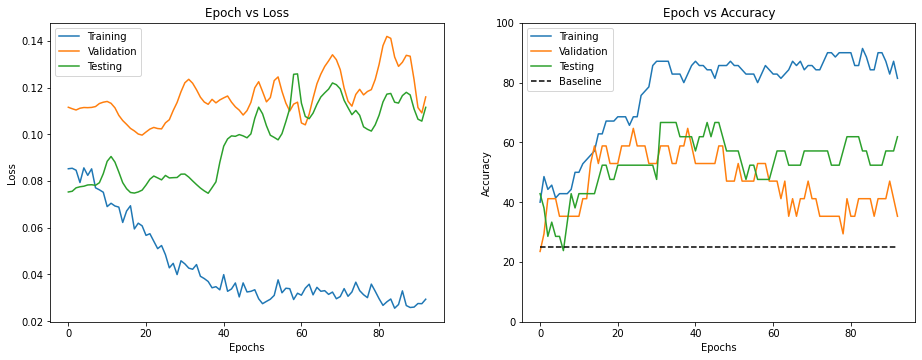

Train/Val/Test Final MSE: [0.03413398712873459, 0.10408137379529174, 0.10765909850929997]
Train/Val/Test Maximum Accuracy: [82.85714285714286, 47.05882352941177, 57.142857142857146]

4/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.07958873212337494 0.09272095193976865 0.0770084437480407
Train/Val/TEST Accuracy: 52.857142857142854 52.94117647058823 33.333333333333336
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.06736642941832542 0.104063621338676 0.06787640650180124
Train/Val/TEST Accuracy: 67.14285714285714 29.41176470588235 66.66666666666667
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.05077692419290543 0.1076890228295644 0.07396626224674817
Train/Val/TEST Accuracy: 70.0 41.1764705882353 71.42857142857143
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.04051944985985756 0.11890661138493348 0.08501136060138899
Train/Val/TEST Accuracy: 78.57142857142857 58.8235294117647 71.42857142857143
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.03196676457300782 0.09984933404142365 0.07903166401887401
Train/Val/TEST Accuracy: 78.57142857142857 64.70588235294117 66.66666666666667
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.037213940918445584 0.09976439569693278 0.08159782675959702
Train/Val/TEST 

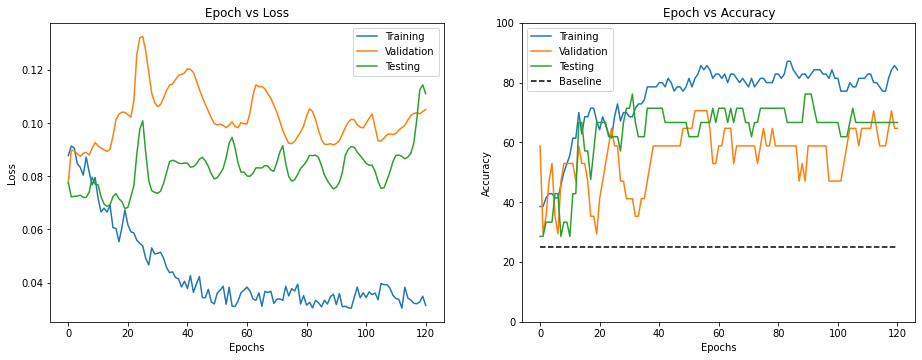

Train/Val/Test Final MSE: [0.03564987927675247, 0.0918788733508657, 0.07529639672499061]
Train/Val/Test Maximum Accuracy: [82.85714285714286, 47.05882352941177, 76.19047619047619]

5/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.07988897562026978 0.09959937270511598 0.07319994417429414
Train/Val/TEST Accuracy: 45.714285714285715 29.41176470588235 47.61904761904762
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.06538543105125427 0.08860850038335603 0.06632929195239697
Train/Val/TEST Accuracy: 64.28571428571429 41.1764705882353 61.904761904761905
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.05041961744427681 0.07438569296808804 0.06862140735167832
Train/Val/TEST Accuracy: 70.0 70.58823529411765 61.904761904761905
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.04191924408078194 0.06499693783767083 0.06645526663799371
Train/Val/TEST Accuracy: 78.57142857142857 82.3529411764706 71.42857142857143
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.04243960753083229 0.07106685487772613 0.07506871015010845
Train/Val/TEST Accuracy: 82.85714285714286 70.58823529411765 57.142857142857146
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.040152174420654774 0.07362692873678445 0.0879300534836061
Train/Val/

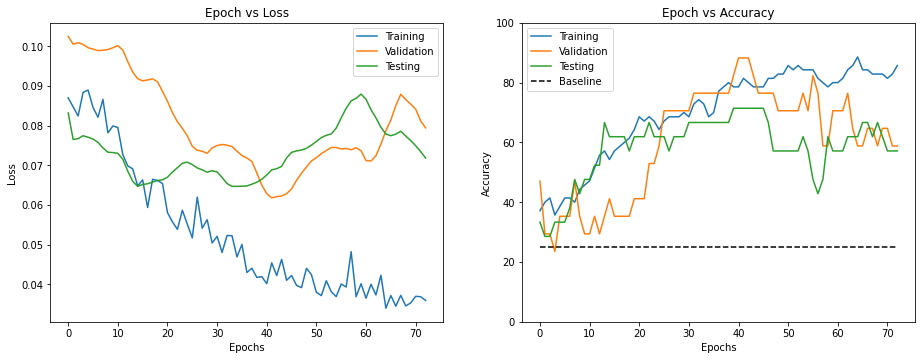

Train/Val/Test Final MSE: [0.045413418859243396, 0.06178635879255393, 0.06883169533518542]
Train/Val/Test Maximum Accuracy: [81.42857142857143, 88.23529411764706, 71.42857142857143]


In [9]:
# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args, CerealTimeKillersLabels, 
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   is_2D = Is_2D_to_quardrant_emotion,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)



In [10]:
# Average results from K-folds
print('Train/Val/Test Average MSE:', list(np.mean(np.array(loss_K), axis = 0)))
print('Train/Val/Test Average Accuracy:', list(np.mean(np.array(acc_K), axis = 0)))


Train/Val/Test Average MSE: [0.042624919265508654, 0.09063518278070976, 0.07498866999521851]
Train/Val/Test Average Accuracy: [81.31262939958592, 49.803921568627445, 68.57142857142858]


## Single prediction results

In [14]:
# Print single prediction results from data loader
fold = 4
ShowDataset = TestDataLoader
ShowModel = models_K[fold]
BATCH_SHOW = 20

ShowModel.eval()

with torch.no_grad():
    for idx, (data, target, quadrant) in enumerate(ShowDataset):
        data = data.type(torch.float).to(args['device'])
        target = target.type(torch.float).to(args['device'])
        quadrant = quadrant.type(torch.float).to(args['device'])
        output = ShowModel(data)
            
        eval_loss = criterion(output, target).item()
        
        if not Is_2D_to_quardrant_emotion:
            predicted = maximum_extraction(output)
            labels = maximum_extraction(target)
        else:
            predicted = emotion_transformation(output)
            flabels = maximum_extraction(quadrant)
            labels = emotion_transformation(target)
        
        eval_acc = maximum_comparison(predicted, labels) * 100.0 / target.size(0)
        
        if idx < BATCH_SHOW:
            print('Batch', idx + 1, ' ( Size', target.size(0), '):')
            print('Output Example:', output[0].detach().numpy(), 'with label ', predicted[0])
            if not Is_2D_to_quardrant_emotion:
                print('Target Example:', target[0].detach().numpy(), 'with label ', labels[0])
            else:
                print('Target Example:', target[0].detach().numpy(), 'with label ', labels[0])
                print('Real Label Example:', quadrant[0].detach().numpy(), 'with label ', flabels[0])
            print('------- MSE:', eval_loss, ' Accuracy:', eval_acc, '%-------\n')
        else:
            print('Etc. for totally ', len(ShowDataset), 'batches.')
            break
 

Batch 1  ( Size 1 ):
Output Example: [0.2403021 0.5533199] with label  [1]
Target Example: [0.125 0.875] with label  [1]
Real Label Example: [ 1. 10.  2.  1.] with label  [1]
------- MSE: 0.058386340737342834  Accuracy: 100.0 %-------

Batch 2  ( Size 1 ):
Output Example: [0.36862427 0.43259233] with label  [0]
Target Example: [0.    0.375] with label  [0]
Real Label Example: [10.  1. 10.  1.] with label  [0, 2]
------- MSE: 0.06960036605596542  Accuracy: 100.0 %-------

Batch 3  ( Size 1 ):
Output Example: [0.50922227 0.47537693] with label  [2]
Target Example: [0.125 0.375] with label  [0]
Real Label Example: [8. 1. 3. 1.] with label  [0]
------- MSE: 0.0788511410355568  Accuracy: 0.0 %-------

Batch 4  ( Size 1 ):
Output Example: [0.20929836 0.30781677] with label  [0]
Target Example: [0.75 0.5 ] with label  [3, 2]
Real Label Example: [1. 1. 5. 8.] with label  [3]
------- MSE: 0.16464632749557495  Accuracy: 0.0 %-------

Batch 5  ( Size 1 ):
Output Example: [0.16823986 0.74146885] w

## 2D emotion plot

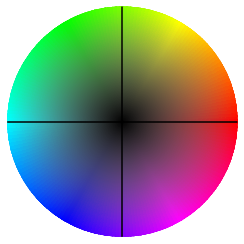

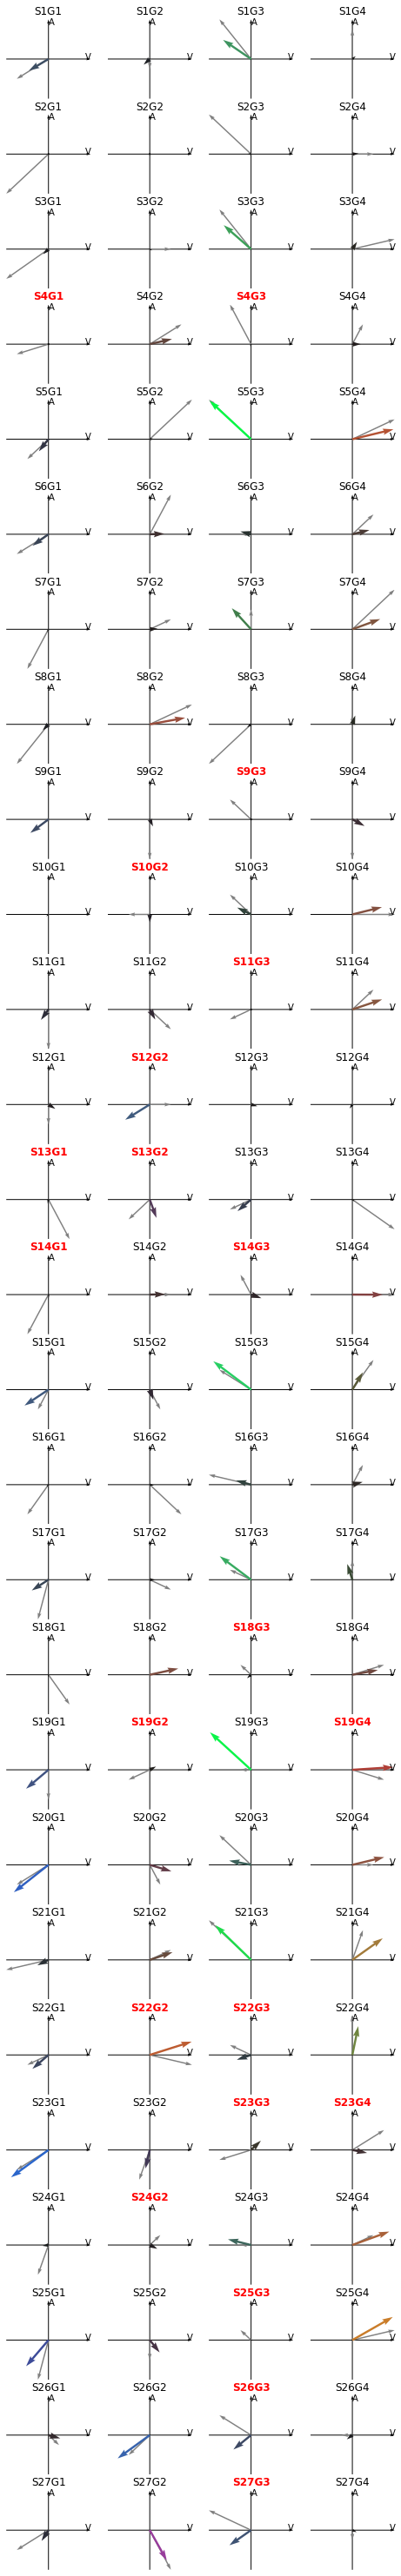

In [13]:
# Plot 2D emotions in a plane for all dataset
if Is_2D_to_quardrant_emotion:
    fold = 4 # select the model trained in the corresponding fold
    TwoD_emotion_plotting(args, models_K[fold], FullDataset, LabelRange, subject = 27, game = 4, plot_disk = True)
